In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.preprocessing import image as img_process
%matplotlib inline

Using TensorFlow backend.


In [2]:
def find_intersections(h, v):
    """
    Given lists of horizontal and vertical lines in (rho, theta) form, returns list
    of (x, y) intersection points.
    """
    points = []
    for d1, a1 in h:
        for d2, a2 in v:
            A = np.array([[np.cos(a1), np.sin(a1)], [np.cos(a2), np.sin(a2)]])
            b = np.array([d1, d2])
            point = np.linalg.solve(A, b)
            points.append(point)
    return points

def draw_intersections(img, intersections):
    for i in range(len(intersections)):
        for row,col in intersections:
            cv2.circle(img,(row, col), 5, (0,255,0), -1)
    
    plt.imshow(img)

In [3]:
def hor_vert_lines(lines):
    """
    A line is given by rho and theta. Given a list of lines, returns a list of
    horizontal lines (theta=90 deg) and a list of vertical lines (theta=0 deg).
    """
    h = []
    v = []
    for i in range(len(lines)):
        distance, angle = lines[i][0]
        if angle < np.pi/6 or angle > np.pi-np.pi/6:
            v.append([distance, angle])
        elif angle > np.pi/3 and angle < np.pi-np.pi/3:
            h.append([distance, angle])
    return h, v

In [4]:
def find_edges(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,250,200)
    return edges

def draw_edges(edges):
    plt.imshow(edges,cmap = 'gray')

In [5]:
def find_lines(edges):
    lines = cv2.HoughLines(edges,1,np.pi/180,200)
    
    for i in range(len(lines)):
        distance, angle = lines[i][0]
        
        if distance < 0:
            lines[i][0][0] = abs(distance)
            lines[i][0][1] = lines[i][0][1] - np.pi
            
    return lines

def draw_lines(img, lines):
    for rho,theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 2000*(-b))
        y1 = int(y0 + 2000*(a))
        x2 = int(x0 - 2000*(-b))
        y2 = int(y0 - 2000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

    plt.imshow(img)

In [15]:
def remove_lines_outliers(lines, threshold):
    '''
        threshold - max distance between two lines
    '''
    lines.sort(key=lambda element: element[0])
    
    segmented_lines = []
    segmented_lines.append([lines[0]])
    
    index = 0
    for i in range(len(lines)-1):
        rho, _ = lines[i]
        rho1, _ = lines[i+1]
        
        if abs(rho-rho1) < threshold:
            segmented_lines[index].append(lines[i+1])
        else:
            index += 1
            segmented_lines.append([])
            segmented_lines[index].append(lines[i+1])
            
    filtered = []
    
    for segment in segmented_lines:
        filtered.append(segment[len(segment)//2])
    
    return filtered

In [16]:
def get_board_lines(hor_lines, vert_lines):
    return hor_lines[1:-1], vert_lines[1:-1]

In [17]:
def get_squares(corners): 
    squares = []
    
    col = 0
    row = 0
    
    squares_cnt = 0
    for i in range(len(corners)-9-1):
        
        if squares_cnt == 8:
            squares_cnt = 0
            continue
            
        top_left = corners[i]
        top_right = corners[i+1]
        bottom_left = corners[i+9]
        bottom_right = corners[i+9+1]
        
        square = [top_left, top_right, bottom_left, bottom_right]
        squares.append(square)
        
        squares_cnt += 1
        
    return squares

In [18]:
def get_square_image(img, square):
    crop_img = img[int(square[0][1]):int(square[2][1]), int(square[0][0]):int(square[1][0])]
    return crop_img

In [19]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory('pictures/dataset',
#                                                  target_size = (128, 128),
#                                                  batch_size = 800,
#                                                  class_mode = 'categorical')

# X, y = training_set.next()
# # print(y)

# import pickle

# # open a file, where you ant to store the data
# file = open('train_data.pickle', 'wb')

# # dump information to that file
# pickle.dump(X, file, protocol=2)
# file.close()


# file = open('train_label.pickle', 'wb')

# # dump information to that file
# pickle.dump(y, file, protocol=2)

# file.close()

# import pickle

# data = pickle.load(open('train_data128.pickle', "rb"))
# label = pickle.load(open('train_label128.pickle', "rb"))


In [20]:
model = load_model('model5.h5')

def predict_image(image):
    
    image = cv2.resize(image,(128, 128))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image/255.
#     plt.imshow(image)
    image = np.expand_dims(image, axis = 0)
    result = model.predict(image)
    
#     print(result)
    return np.argmax(result[0])

In [21]:
pieces = {
    0: 'bb', 1: 'bh', 2: 'bk', 3: 'bp', 4: 'bq', 5: 'br', 6: 'nn',
    7: 'wb', 8: 'wh', 9: 'wk', 10: 'wp', 11: 'wq', 12: 'wr'
}

---------------------------------------
nn | nn | nn | nn | nn | nn | nn | nn | 
---------------------------------------
nn | wp | nn | nn | nn | nn | nn | nn | 
---------------------------------------
nn | nn | nn | nn | nn | nn | wb | nn | 
---------------------------------------
nn | wp | nn | wp | nn | nn | nn | nn | 
---------------------------------------
nn | bb | wb | bb | nn | nn | wh | nn | 
---------------------------------------
nn | wp | nn | nn | bb | wb | nn | wp | 
---------------------------------------
wp | bb | wp | nn | nn | bp | wp | bb | 
---------------------------------------
bb | wb | bb | nn | bp | nn | br | nn | 
---------------------------------------


True

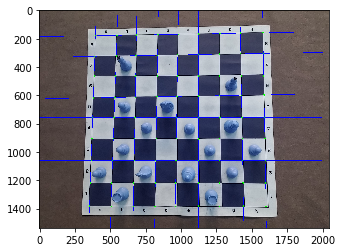

In [23]:
img = cv2.imread('pictures/for_test/20190217_135703.jpg')
edges = find_edges(img)

cv2.imwrite('edges.jpg',edges)

lines = find_lines(edges)
hor_lines, vert_lines = hor_vert_lines(lines)

filtered_hor_lines = remove_lines_outliers(hor_lines, 25)
filtered_vert_lines = remove_lines_outliers(vert_lines, 25)

board_hor_lines, board_vert_lines = get_board_lines(filtered_hor_lines, filtered_vert_lines)

intersections = find_intersections(board_hor_lines, board_vert_lines)
squares = get_squares(intersections)
pieces_list = []

for square in squares:
    square_img = get_square_image(img, square)
    piece_index = predict_image(square_img)
    pieces_list.append(pieces[piece_index])
    
cnt = 0

print("---------------------------------------")
for i in range(64):
    print(pieces_list[i] + " | ", end = '')
    cnt += 1
    if cnt == 8:
        print("\n---------------------------------------")
        cnt = 0

    
draw_lines(img, board_hor_lines)
draw_lines(img, board_vert_lines)
draw_intersections(img, intersections)

cv2.imwrite('houghlines_intersections.jpg',img)
